### Installing required libraries

In [ ]:
pip install neuralforecast==1.7.3 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 12.1 MB/s eta 0:00:00
Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import GMM, MQLoss, DistributionLoss
from neuralforecast.auto import TCN
from neuralforecast.tsdataset import TimeSeriesDataset
from ray import tune

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set and split data into **train** and **test**

In [ ]:

from neuralforecast.utils import AirPassengersDF as Y_df
# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train data
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test data
dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)

Lets initialize and training model (**TCN**) and define its hyperparameters.

In [ ]:
horizon = 12

fcst = NeuralForecast(
    models=[TCN(h=horizon,
                input_size=-1,
                #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                loss=GMM(n_components=7, return_params=True, level=[80,90]),
                learning_rate=5e-4,
                kernel_size=2,
                dilations=[1,2,4,8,16],
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=500,
                scaler_type='robust',
                #futr_exog_list=['y_[lag12]'],
                hist_exog_list=None,
                #stat_exog_list=['airline1'],
                )
    ],
    freq='M'
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
fcst.fit(df =Y_train_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | GMM                        | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 131 K  | train
4 | context_adapter | Linear                     | 15.5 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
150 K     Trainable params
5         Non-trainable params
150 K     Total params
0.603     Total estimated

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


Predict for the next defined horizon

In [ ]:
y_hat = fcst.predict()
y_hat.set_index('ds',inplace =True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
y_hat

,TCN,TCN-median,TCN-lo-90,TCN-lo-80,TCN-hi-80,TCN-hi-90,TCN-mu-1,TCN-std-1,TCN-mu-2,TCN-std-2,TCN-mu-3,TCN-std-3,TCN-mu-4,TCN-std-4,TCN-mu-5,TCN-std-5,TCN-mu-6,TCN-std-6,TCN-mu-7,TCN-std-7
ds,,,,,,,,,,,,,,,,,,,,
1960-01-31,399.866486,400.442200,370.854034,378.432098,421.345367,427.704620,404.990723,15.600019,391.500183,15.600014,409.794250,15.600022,397.643433,15.600007,388.499878,15.600026,397.181091,15.600014,408.545105,15.600035
1960-02-29,408.066925,408.250916,372.417664,380.781403,436.946503,443.140747,412.740601,15.600007,386.670105,15.600008,395.573120,15.600008,421.659851,15.600014,393.826599,15.600004,420.483093,15.600008,425.228546,15.600022
1960-03-31,431.713684,433.548218,395.079865,403.510925,456.927521,464.503021,443.772888,15.600001,435.004578,15.600010,450.948792,15.600006,433.966583,15.600013,425.590485,15.600007,428.784180,15.600007,403.745850,15.600005
1960-04-30,419.090576,421.557922,379.846100,385.572418,447.335663,454.024139,429.013062,15.600054,431.354309,15.600049,427.829102,15.600060,435.109619,15.600014,388.567810,15.600058,394.589844,15.600049,429.600891,15.600101
1960-05-31,454.663055,454.354858,428.451569,433.997437,475.399902,482.697113,457.120239,15.600002,450.128662,15.600010,448.979980,15.600005,451.908142,15.600006,447.906616,15.600013,461.429108,15.600006,467.475403,15.600005
1960-06-30,541.898132,542.239075,514.860168,520.419983,562.942505,568.845459,541.832886,15.600001,535.204895,15.600001,543.532654,15.600001,537.940796,15.600004,539.302612,15.600001,539.022095,15.600006,549.630615,15.600007
1960-07-31,628.087097,627.971863,601.533142,607.835327,648.051758,653.913208,625.829651,15.600004,636.416260,15.600007,627.906006,15.600007,625.075928,15.600006,623.032654,15.600039,630.268860,15.600020,629.257568,15.600047
1960-08-31,609.679993,609.858276,583.139465,589.567383,630.630676,635.338440,609.950806,15.600022,610.670410,15.600019,611.897522,15.600011,606.996216,15.600023,608.490479,15.600092,608.959473,15.600181,615.569458,15.600079
1960-09-30,505.650330,505.092346,474.978363,482.215088,529.354309,535.703186,509.586700,15.600001,508.068878,15.600007,522.086975,15.600004,509.482056,15.600012,496.549896,15.600027,493.765381,15.600007,501.929291,15.600005


Measure the models accuracy

In [ ]:
calculate_error_metrics(Y_test_df[['y']],y_hat[['TCN']])

MSE : 433.3346862792969
RMSE : 20.816692352294922
MAPE : 0.03554682061076164
r2 : 0.9217732930276429
adjusted_r2 : 0.9139506223304071


Visualize the predictions

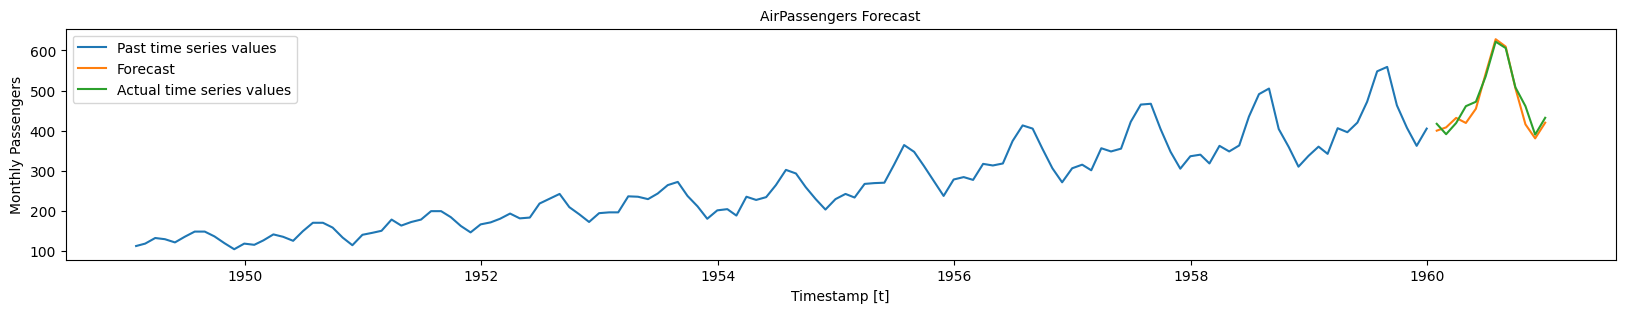

In [ ]:
Y_train_df.set_index('ds',inplace =True)
#y_hat.set_index('ds',inplace =True)
Y_test_df.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

y_past = Y_train_df["y"]
y_pred = y_hat[['TCN']]
y_test = Y_test_df["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();